In [107]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
from torch import nn
from torch.nn import functional as f

from utils import flat_to_triangular, make_cholesky, plot, clean_curr_axes, onehot, log_sum_exp

np.random.seed(3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

COLORS = sns.color_palette()

def _npz(fn, *args, **kwargs):
    args = [t.cpu().detach().numpy() if isinstance(t, torch.Tensor) else t for t in args]
    kwargs = {k:t.cpu().detach().numpy() if isinstance(t, torch.Tensor) else t for k,t in kwargs.items()}
    return fn(*args, **kwargs)

# Deep Bayes: Bayesian Regression using Deep Basis Functions

## 0. Introduction

### Data

Let be for $t \in \mathcal{R}$ and  $x \in \mathcal{R}$ a generative process $p(t\ |\  x, \mathbf{w}, \phi, \sigma)$ such as $\exists\ d \in \mathbb{N}, \mathbf{w} \in \mathcal{R}^{1 \times d}, \phi \in \mathbb{R}^{d \times 1}, \sigma \in \mathbb{R}$ such as:

\begin{align}
p(t\ |\  x, \mathbf{w}, \phi, \sigma) & = \mathcal{N}(\mathbf{w} \phi(x_i), \sigma^2) 
\end{align}



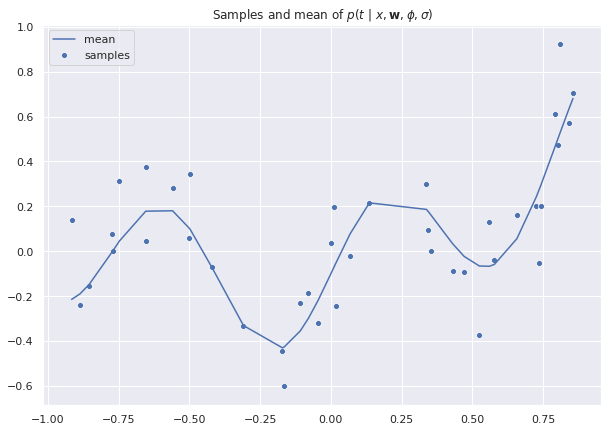

In [109]:
N_axis = 256
N = 40
true_a = torch.tensor([.3, .5, .3], device=device).view(-1, 1)
true_b = torch.tensor(0.2, device=device)
sigma = torch.tensor(0.15, device=device)  # observation noise

# create axis data (for visualization)
x = torch.tensor((np.random.rand(N_axis) * 2 - 1).reshape(-1, 1), dtype=torch.float, device=device)
x,_ = torch.sort(x, dim=0)
fx1 = x - 1
fx2 = x**2
fx3 = torch.sin(8 * x)
x_axis = x
fx_axis = torch.cat((fx1, fx2, fx3), dim=-1)

# create data
x = torch.tensor((np.random.rand(N) * 2 - 1).reshape(-1, 1), dtype=torch.float, device=device)
x,_ = torch.sort(x, dim=0)
fx1 = x - 1
fx2 = x**2
fx3 = torch.sin(8 * x)
fx = torch.cat((fx1, fx2, fx3), dim=-1)
t = fx @ true_a + true_b + sigma*torch.ones(x.shape, device=device).normal_()  # observations
plt.figure(figsize=(10, 7))

_npz(plt.plot, x, fx @ true_a + true_b, label='mean')
# plt.plot(x, fx, alpha=0.3)
_npz(sns.scatterplot, x[:, 0], t[:, 0], label='samples')
plt.title(r'Samples and mean of $p(t\ |\  x, \mathbf{w}, \phi, \sigma)$')
plt.show() 

## 1. Bayesian Regression with Known Basis Functions



In the case of a known deterministic $d$-dimensional basis function $\phi$, the likelihood of a data point $(x_i, t_i)$ is:

\begin{align}
p(t_i \ |\ \mathbf{w}, x_i; \sigma^2) & = \mathcal{N}(\mathbf{w} \phi(x_i), \sigma^2) 
\end{align}

We define the prior over the parameters as an isotropic Gaussian:

\begin{align}
 p(\mathbf{w}) = \mathcal{N}(0,\mathbf{I})
\end{align}

The posterior of the parameters, with $(\mathbf{x}, \mathbf{t})$ the entire dataset, is:

\begin{align}
p(\mathbf{w} \ |\ \mathbf{t} , \mathbf{x}; \sigma^2) = \frac{p(\mathbf{t} \ |\  \mathbf{w}, \mathbf{x}; \sigma^2) p(\mathbf{w})}{p(\mathbf{t}\ |\ \mathbf{x}; \sigma^2)}
\end{align}

The denominator $p(\mathbf{t} \ |\ \mathbf{x}; \sigma^2)$ is tractable and constant, hence we can also approximate the posterior using our favorite MCMC methods. The analytical expression of the posterior is:

\begin{align}
p(\mathbf{w}\ |\ \mathbf{t} , \mathbf{x}; \sigma^2) = \mathcal{N}(\mu_p , \Sigma_p) 
\end{align}

with

\begin{align}
\Sigma_p = \left( I + \frac{1}{\sigma^2} \phi(x)^T \phi(x) \right)^{-1} \qquad \mu_p = \Sigma \frac{1}{\sigma^2} \phi(x)^T  t \ .
\end{align}

The following code computes and sample the approximate posterior using the known basis functions.

In [110]:
from torch.distributions import MultivariateNormal

class RegressionPosterior(MultivariateNormal):
    def __init__(self, fx, t, sigma):
        fx_ = self.get_basis(fx)
        I = torch.eye(fx_.shape[1], device=device)
        cov = torch.inverse(I + 1.0/sigma**2 * fx_.transpose(1,0) @ fx_)
        mu = 1.0 / sigma**2 * cov @ fx_.transpose(1,0) @ t
        super().__init__(mu.squeeze(), cov)
        self.sigma = sigma
        
    @staticmethod
    def get_basis(fx):
        return torch.cat([fx, torch.ones_like(fx[:,:1])], 1)
    
    def sample_weights(self, *args, **kwargs):
        weights = super().sample( *args, **kwargs)
        weights = weights.unsqueeze(-1)
        return weights
        
    def sample(self, fx, *args, **kwargs):
        weights = self.sample_weights(*args, **kwargs)
        fx_ = self.get_basis(fx)
        mean = fx_ @ weights
        return mean + self.sigma * torch.ones_like(mean).normal_()
    
    def plot_scatter(self, x, fx, n_samples=1):
        t_samples = self.sample(fx, (n_samples,))
        x = x.squeeze(-1).unsqueeze(0).expand(n_samples, -1,).contiguous()
        _npz(plt.scatter, x.view(-1), t_samples.view(-1), color='gray', alpha=0.3, label='Posterior sample')
        
    def plot_ci(self, x, fx, n_samples):
        t_samples = self.sample(fx, (n_samples,)).squeeze().cpu().data.numpy()
        x = x.squeeze().cpu().data.numpy()
        
        p = np.percentile(t_samples, [2.5,97.5], axis=0)
        plt.fill_between(x, p[0], p[1], alpha=0.1, label="95% CI", color=COLORS[1])
        
        p = np.percentile(t_samples, [25,75], axis=0)
        plt.fill_between(x, p[0], p[1], alpha=0.2, label="50% CI", color=COLORS[1])
        
        
    def plot(self, x, fx, n_samples=512):
        self.plot_scatter(x,fx,1)
        self.plot_ci(x, fx, n_samples)
        
        

In [111]:
posterior = RegressionPosterior(fx, t, sigma)

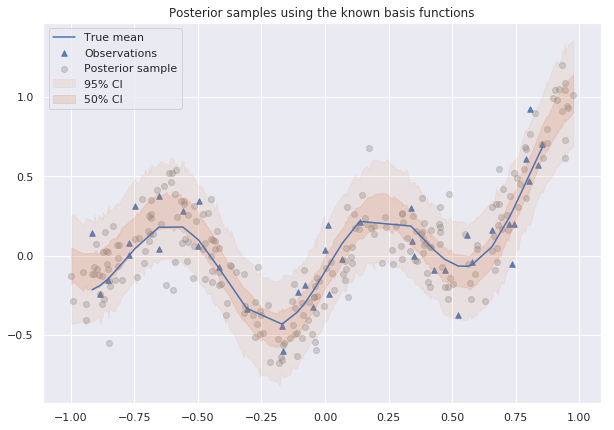

In [112]:
plt.figure(figsize=(10, 7))
_npz(plt.plot, x, fx @ true_a + true_b, label="True mean", color=COLORS[0])
_npz(plt.scatter, x[:, 0], t[:, 0], label='Observations', alpha=0.9, color=COLORS[0], marker='^', s=30)
posterior.plot(x_axis,fx_axis)
plt.title('Posterior samples using the known basis functions')
plt.legend();plt.show()

## 3. Problem: How to perform Bayesian Regression in the case of Unknown basis functions?

The classical approach consists in using a fixed set of transformations as basis functions (e.g. $sin(x), x^2, x^3$, etc..)). However this approach lacks of generality, fails to scale to more complex problems such as logistic regression on a set of images (see MNIST experiment) and requires expert knowledge to design the basis functions.

We propose to solve this problem using parametric basis functions $\phi_{\theta}$ (implemented using neural networks) and by approximating the posterior $p(\mathbf{w}\ |\ D)$ using Variational Inference, which allows us to train the entire model end-to-end.

## 4. Bayesian Regression with learnt basis function $\phi_{\theta}$

In this section we use Variational Inference to approximate the true posterior $p(\mathbf{w}\ |\ \mathbf{t} , \mathbf{x}; \sigma^2)$ and optimize the parameters of the basis function $\phi_{\theta}$ using maximum likelihood.

Variational Inference consists in approximating the true posterior using a family of parametric distributions. We parametrize the posterior of the parameters $\mathbf{w}$ using a Multivariate Gaussian parametrized by parameters $\mu$ and $\Sigma$. Note that we are using an Isotropic Gaussian prior and we know that the posterior is conjugate to the prior. Hence, using such a parametric posterior should yield a good approximation, which quality depends on performances of the optimization algorithm.

We learn the variational parameters **and** the basis parameters using backproagation (Bayes by Backprop), this is possible thanks to the reparametrization trick [1], [2]:

The reparametrization trick [1], [2] is usually applied using a Diagonal Posterior. As this assumption can limit the expressivity of our model, we use apply the reparametrization trick to Multivariate Gaussians.


#### Bayes by Backprop

Let $\mathbf{w}$ be the vector with all the parameters $\mathbf{a}$ and $b$, having size $D' = D+1$. As basis function we use $f_\theta$, a neural network parameterized by a vector $\theta$. This effectively corresponds to a neural network where the last layer is Bayesian.

We approximate the posterior parameter distribution $p(\mathbf{w} \ |\ \mathcal{D})$ with

$$q(\mathbf{w}) = \mathcal{N}(\boldsymbol{\mu}_{\mathbf{w}}, \boldsymbol{\Sigma}_{\mathbf{w}})$$

and optimize this distribution with variational inference, whereas $\theta$ and $\sigma^2$ are estimated by maximum likelihood. We do this by deriving a lower bound (**ELBO**) of the marginal log likelihood that we can optimize end-to-end with respect to $\theta$, $\sigma^2$, $\boldsymbol{\mu}_{\mathbf{w}}$, and $ \boldsymbol{\Sigma}_{\mathbf{w}}$. We have:

\begin{align}
\log p(\mathbf{t} | \mathbf{x};\theta) & = \log \int_{\mathbf{w}} p(\mathbf{t}, \mathbf{w} \ |\  \mathbf{x};  \theta) d\mathbf{w} \\
& = \log \int_{\mathbf{w}} p(\mathbf{t} \ |\  \mathbf{w}, \mathbf{x};  \theta)p(\mathbf{w}) d\mathbf{w} \\
& = \log \int_{\mathbf{w}} q(\mathbf{w}) p(\mathbf{t} \ |\  \mathbf{w}, \mathbf{x};  \theta) \frac{p(\mathbf{w})}{q(\mathbf{w})} d\mathbf{w} \\
& \geq \mathbb{E}_{q(\mathbf{w})} \left[ \log  p(\mathbf{t} \ |\ \mathbf{w}, \mathbf{x}; \theta) \frac{p(\mathbf{w})}{q(\mathbf{w})} \right] \\
& = \mathbb{E}_q[\log p(\mathbf{t}\ |\ \mathbf{w}, \mathbf{x}; \theta)] - \mathrm{KL}(q(\mathbf{w}) \ ||\ p(\mathbf{w})) \\
&= \mathcal{L (q,\theta, \sigma^2)}
\end{align}

#### Modelling the posterior of vector quantities with covariance

We choose to model the approximate posterior of $\mathbf{w}$ using a **Multivariate Gaussian** where the covariance matrix $\boldsymbol{\Sigma}$ is parametrized by using the Cholesky decomposition $\boldsymbol{\Sigma}=\mathbf{L}\mathbf{L}^T$, which allows us to apply the reparametrization trick [3], [4]:

\begin{align}
\mathbf{w} = \boldsymbol{\mu} + \mathbf{L} \boldsymbol{\epsilon}, \quad 
\boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I}) \quad \Rightarrow \quad
\mathbf{w} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})
\end{align}

where we can easily see that the mean of $\mathbf{w}$ is $\boldsymbol{\mu}$, and the covariance is indeed $\boldsymbol{\Sigma}$:

\begin{aligned}
\mathrm{cov} (\mathbf{w}) &=\mathbb{E}\left[(\mathbf{w}-\mathbb{E}[\mathbf{w} ])(\mathbf{w}-\mathbb{E}[\mathbf{w} ])^{T}\right] \\ 
&=\mathbb{E}\left[\mathbf{L} \boldsymbol{\epsilon}(\mathbf{L} \boldsymbol{\epsilon})^{T}\right] \\ 
&=\mathbb{E}\left[\mathbf{L} \boldsymbol{\epsilon} \boldsymbol{\epsilon}^{T} \mathbf{L}^{T}\right] \\ 
&=\mathbf{L} \mathbb{E}\left[\boldsymbol{\epsilon} \boldsymbol{\epsilon}^{T}\right] \mathbf{L}^{T} \\ 
&=\mathbf{L} \mathbf{L}^{T} = \boldsymbol{\Sigma}
\end{aligned}


The two terms we need to compute the ELBO are as follows:

\begin{split}
\mathbb{E}_q[\log p(\mathbf{t}\ |\ \mathbf{a}, b, \mathbf{x} ; \theta, \sigma^2)] &=  \mathbb{E}_q \left[ \sum_{i = 1}^N \left[ -\frac{1}{2} \log \sigma^2 - \frac{1}{2\sigma^2} [(t_i - \mathbf{a} f_{\theta}(x_i) - b)^2] + \mathrm{const.} \right] \right] \\
\mathrm{KL}(q(\mathbf{w}) \ ||\ p(\mathbf{w})) &= -\frac{1}{2} \sum_{i=1}^{D'} \left(1 + \log L_{i,i}^2 - \mu_i^2 - \Sigma_{i,i}\right)
\end{split}
where $N$ is the data set size.

Here we used the KL divergence between multivariate Gaussian distributions:
\begin{aligned}
\mathrm{KL}(q\ ||\ p))
    &= \frac{1}{2} \left( \log |\boldsymbol{\Sigma}_ p| - \log |\boldsymbol{\Sigma}_ q| - D' + \mathrm{tr} (\boldsymbol{\Sigma}_p^{-1} \boldsymbol{\Sigma}_q) + (\boldsymbol{\mu}_p - \boldsymbol{\mu}_q)^T  \boldsymbol{\Sigma}_p (\boldsymbol{\mu}_p - \boldsymbol{\mu}_q)\right) \\
    & = \frac{1}{2} \left( - \log \left(|\boldsymbol{L}|^2\right) - D' + \mathrm{tr} (\boldsymbol{\Sigma}_q) +  \boldsymbol{\mu}_q^T \boldsymbol{\mu}_q\right) \\
    & = -\frac{1}{2} \left(D' + \sum_{i=1}^{D'} \log L_{ii}^2 - \sum_{i=1}^{D'} (\boldsymbol{\Sigma}_q)_{ii} - \sum_{i=1}^{D'} \mu_i^2 \right)
\end{aligned}

### References

[1] [Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013).](https://arxiv.org/abs/1401.4082)

[2] [Rezende, Danilo Jimenez, Shakir Mohamed, and Daan Wierstra. "Stochastic backpropagation and approximate inference in deep generative models." arXiv preprint arXiv:1401.4082 (2014).](https://arxiv.org/abs/1312.6114)

[3] [Diederik P. Kingma, "Variational Auto-Encoders", talk @ Berkley](https://berkeley-deep-learning.github.io/cs294-131-s17/slides/VAE%20talk.compressed.pdf)

[4] [Jankowiak, Martin, and Fritz Obermeyer. "Pathwise Derivatives Beyond the Reparameterization Trick." arXiv preprint arXiv:1806.01851 (2018).](https://arxiv.org/pdf/1806.01851.pdf)

### Features extractor $\phi_\theta$ and the stochastic layer $q(\mathbf{w})$

Define function $f_{\theta}$ to extract features $h = f_{\theta}(x)$, with parameters $\theta$ to be optimized.

The stochastic layer has no state, it's only used to get samples from $\mathcal{N}(\mu, \sigma^2)$, and to compute the KL divergence from a prior $\mathcal{N}(0, 1)$ to a variational distribution $q = \mathcal{N}(\mu, \sigma^2)$.

In [52]:
class FeaturesExtractor(nn.Module):
    def __init__(self, n_out):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32), nn.ReLU(),
            nn.Linear(32, n_out))
        
    def forward(self, x):
        return self.layers(x)
    
    
class CovarianceStochasticLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_q, cholesky):
        eps = torch.randn_like(mu_q)
        return mu_q + cholesky @ eps

    def get_kl(self, mu_q, L_logdiag_q, L_q):
        kl = -0.5 * (1 + L_logdiag_q - mu_q.pow(2) - torch.diag(L_q @ L_q.permute(1, 0)))
        return kl.sum()

### Optimization
We maximize the ELBO $\mathcal{L}$ with respect to variational parameters, the NN parameters $\theta$, and the noise std $\sigma$. Note that we use $\mathbf{w} = (a,b)$

In [88]:
features = FeaturesExtractor(n_out=true_a.shape[0]).to(device)
stochastic = CovarianceStochasticLayer().to(device)
stochastic
l_rate = 0.01
epochs = 10000
n_samples = 5  # MC samples per example
n_parameters = true_a.numel() + true_b.numel()
mu_ab = nn.Parameter(torch.zeros((n_parameters), device=device))  # for a and b 

# diagonal covariance
logvar_ab = nn.Parameter(torch.zeros((n_parameters), device=device))

# off-diagonal covariance
cov_ab_params = nn.Parameter(torch.zeros((n_parameters*(n_parameters-1)//2), device=device).normal_() * 0.0)

# noise scale sigma
logvar = nn.Parameter(torch.tensor(0., device=device)) 

optimiser = torch.optim.Adam(list(features.parameters()) + [mu_ab, logvar_ab, logvar, cov_ab_params], lr = l_rate)

for epoch in range(epochs):
    optimiser.zero_grad()
    h = features(x)
    cov_ab = flat_to_triangular(cov_ab_params)
    L = make_cholesky(logvar_ab, cov_ab)
    elbo = torch.zeros((n_samples), device=x.device)
    for i in range(n_samples):
        ## Sample once from q(a) q(b)
        ab_sample = stochastic(mu_ab, L)
        a, b = ab_sample[:-1], ab_sample[-1:]
        a = a.unsqueeze(1)
        
        y = h @ a + b  # stochasticity here only comes from a and b
        expected_mse_i = (t - y)**2
    
        ## Reconstruction loss, estimated by MC
        recons_i = (0.5/logvar.exp() * expected_mse_i + 0.5*logvar)  # recons per example
    
        ## Compute KL
        kl_i = stochastic.get_kl(mu_ab, logvar_ab, L)
    
        elbo[i] = - recons_i.sum() - kl_i
        
    elbo = elbo.mean()
    
    loss = - elbo
    loss.backward()
    optimiser.step()
    if epoch % 500 == 0 or epoch == epochs-1:
        print(f'epoch {epoch} : loss {loss.data.item():.3f} ELBO {elbo.data.item():.3f}  Reconstruction {recons_i.sum().data.item():.3f}  KL {kl_i.sum().data.item():.3f}')
      

epoch 0 : loss 24.746 ELBO -24.746  Reconstruction 9.026  KL 0.000
epoch 500 : loss -25.206 ELBO 25.206  Reconstruction -33.232  KL 2.568
epoch 1000 : loss -51.221 ELBO 51.221  Reconstruction -55.944  KL 4.924
epoch 1500 : loss -58.371 ELBO 58.371  Reconstruction -66.693  KL 6.041
epoch 2000 : loss -61.168 ELBO 61.168  Reconstruction -66.756  KL 6.233
epoch 2500 : loss -58.550 ELBO 58.550  Reconstruction -68.243  KL 6.338
epoch 3000 : loss -60.237 ELBO 60.237  Reconstruction -65.722  KL 6.282
epoch 3500 : loss -59.716 ELBO 59.716  Reconstruction -63.687  KL 6.419
epoch 4000 : loss -54.135 ELBO 54.135  Reconstruction -68.103  KL 6.565
epoch 4500 : loss -59.315 ELBO 59.315  Reconstruction -67.302  KL 6.501
epoch 5000 : loss -60.587 ELBO 60.587  Reconstruction -66.638  KL 6.496
epoch 5500 : loss -60.744 ELBO 60.744  Reconstruction -68.404  KL 6.424
epoch 6000 : loss -59.986 ELBO 59.986  Reconstruction -69.118  KL 6.459
epoch 6500 : loss -61.780 ELBO 61.780  Reconstruction -66.923  KL 6.54

### Posterior

The following code presents the learned paramteric Covariance. Most interestingly, the model is able to exploit the covariance structure given our Cholesky parametrization.

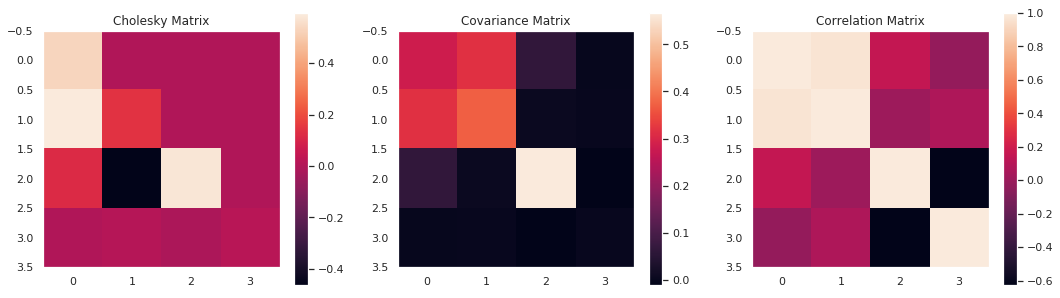

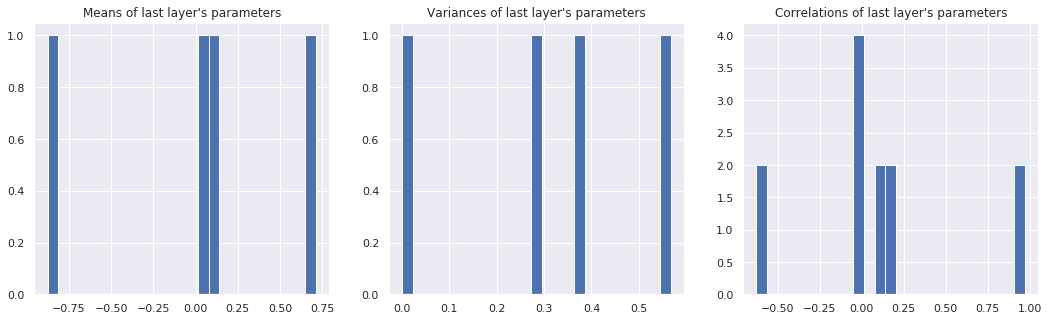

In [89]:
L = make_cholesky(logvar_ab, cov_ab).detach().cpu().numpy()
Cov = L @ L.T
inv_stds = np.diag(np.diag(Cov)**(-0.5))
Corr = inv_stds @ Cov @ inv_stds

plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
plt.title("Cholesky Matrix"), plt.grid(False)
plt.imshow(L)
plt.colorbar()

plt.subplot(1,3,2)
plt.title("Covariance Matrix"), plt.grid(False)
plt.imshow(Cov)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("Correlation Matrix"), plt.grid(False)
plt.imshow(Corr)
plt.colorbar()
plt.show()

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.title("Means of last layer's parameters")
plt.hist(mu_ab.cpu().detach(), bins=25)
plt.subplot(1, 3, 2)
plt.title("Variances of last layer's parameters")
plt.hist(np.diag(Cov), bins=25)
plt.subplot(1, 3, 3)
plt.title("Correlations of last layer's parameters")  # corr coefficients between pairs of DIFFERENT variables
correlations = Corr[~np.eye(Corr.shape[0], dtype=bool)]
plt.hist(correlations, bins=25)
plt.show()

### Posterior Samples

We sample $a,b \sim q(a,b)$ according to the learned variational parameters. Get $N$ samples $a_i$ and $b_i$. Then sample from predictive distribution
$$t_i = a_i f_{\theta}(x_i) + b_i + \sigma \epsilon_i$$
with $\epsilon_i$ iid samples from $\mathcal{N}(0,1)$.

Estimated noise std: 0.117 - true std: 0.15
Sample parameters 5000 times from their posterior, and each time generate predictions on 100 equally spaced points using random noise with estimated variance.


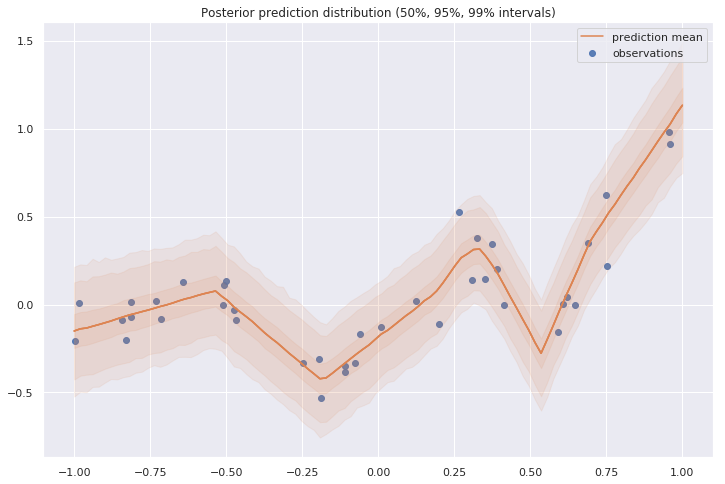

In [90]:
print('Estimated noise std: {:.3g} - true std: {:.3g}'.format((logvar/2).exp().cpu().detach().numpy(), sigma))

n_samples = 5000
n_points = 100
post_samples_all = []
print('Sample parameters {} times from their posterior, and each time generate predictions on {} equally spaced points using random noise with estimated variance.'.format(n_samples, n_points))
plt.figure(figsize=(12, 8))
x_ = np.linspace(-1, 1, n_points).reshape(-1, 1)
x_ = torch.tensor(x_).float().to(device)
for s in range(n_samples):
    ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
    a, b = ab_sample[:-1], ab_sample[-1:]
    a = a.unsqueeze(1)

    a = a.detach().cpu().numpy()
    b = b.detach().cpu().numpy()

    h_ = features(x_).detach().cpu().numpy()   # shape (N, 3)
    post_samples_mean = h_ @ a + b
    post_samples = post_samples_mean + (logvar/2).exp().detach().cpu().numpy() * np.random.randn(*x_.shape)
    post_samples_all.append(post_samples[None, :, 0])

post_samples_all = np.concatenate(post_samples_all, axis=0)
post_samples_mean = np.mean(post_samples_all, axis=0)
post_samples_perc = np.percentile(post_samples_all, [0.5, 2.5, 25, 75, 97.5, 99.5], axis=0)
x_np_ = x_.squeeze(-1).detach().cpu().numpy()
plt.scatter(x.cpu(), t.cpu(), alpha=0.9, label='observations'.format(s))
plot(x_np_, post_samples_mean, y_lower=post_samples_perc[0], y_upper=post_samples_perc[-1], 
     alpha=0.1, label='prediction mean', color=sns.color_palette()[1])
plot(x_np_, post_samples_mean, y_lower=post_samples_perc[1], y_upper=post_samples_perc[-2], 
     alpha=0.1, color=sns.color_palette()[1])
plot(x_np_, post_samples_mean, y_lower=post_samples_perc[2], y_upper=post_samples_perc[-3], 
     alpha=0.1, color=sns.color_palette()[1])
plt.title('Posterior prediction distribution (50%, 95%, 99% intervals)')

plt.legend()
plt.show()

## 5. Deep Classifier with Bayesian Likelihood$

Overfitting is a fondamental issue in Deep Learning because it relies on the use of powerful function approximators (neural network) and Maximum Likelihood Estimation. This regression problem highlights well the ability of our method to combine uncertainty estimation with neural networks. Can we extend this method to classification problems?

We consider a classification problem with $K$ classes, inputs $\mathbf{x}$, and target classes $\mathbf{t}$, where each target $t_i$ is a scalar denoting the class of $x_i$. We wish to learn a bayesian linear model with learnt basis functions, and take the output of such model as score for the different classes.

The model is similar to the one used in the regression case, only the likelihood changes. The predicted probability for the different classes for example $x_i$ is:

\begin{align}
    \mathbf{y} = \mathrm{softmax} (\mathbf{a} \phi(x_i) + \mathbf{b})
\end{align}

where $\mathbf{y}$ and $\mathbf{b}$ are $K$-vectors, $\mathbf{a}$ is a $K \times D$ matrix, and the softmax is computed over the $K$ classes.
The likelihood of a data point $(x_i, t_i)$ is:

\begin{align}
p(t_i \ |\ \mathbf{a}, \mathbf{b}, x_i) & = y[t_i]
\end{align}


i.e. the model output for the true class $t_i$. Assuming independence, the likelihood of the parameters given the entire dataset is simply the product of the above.

### Toy Dataset

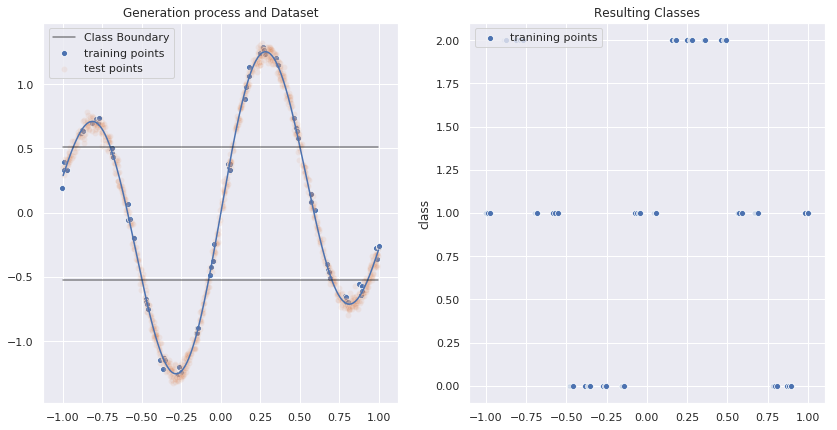

In [115]:
N = 80    # data points
duplicate_factor = 4
duplicate_sigma = 0.01
N_test = 1000  # test data points
sigma = .04  # final noise
n_classes = 3

## Random clusters of data points
x = np.linspace(-1.0, 1.0, N//duplicate_factor).reshape(-1, 1)
# x = np.random.rand(N//duplicate_factor, 1) * 2 - 1
noise = np.random.randn(N//duplicate_factor, duplicate_factor) * duplicate_sigma
x = x + noise
x = x.reshape(N, 1)

x_test = np.random.rand(N_test, 1) * 2 - 1

x = np.concatenate((x_test, x), axis=0)

fx = -x**3 + x + np.sin(6 * x)
noisy_fx = fx + sigma*np.random.randn(*x.shape)  # function to compute labels

# Divide data interval in n_classes regions
thresholds = np.percentile(noisy_fx, np.linspace(0, 100, n_classes+1))  # balanced classes

# targets
t = np.zeros((noisy_fx.shape[0], n_classes), dtype=int)  # one-hot, shape (N, C)
for i in range(n_classes):
    t[:, i] = ((thresholds[i] < noisy_fx) * (thresholds[i+1] >= noisy_fx))[:, 0]
t_values = t * np.arange(n_classes).reshape((1, -1))
t_values = np.sum(t_values, 1)

x_test = x[:N_test]
x = x[N_test:]
fx_test = fx[:N_test]
fx = fx[N_test:]
noisy_fx_test = noisy_fx[:N_test]
noisy_fx = noisy_fx[N_test:]
t_test = t[:N_test]
t = t[N_test:]
t_values_test = t_values[:N_test]
t_values = t_values[N_test:]

test_sort_idx = np.argsort(x_test, axis=0).flatten()
x_test, fx_test, noisy_fx_test, t_test, t_values_test = (
    tensor[test_sort_idx] for tensor in [x_test, fx_test, noisy_fx_test, t_test, t_values_test])
sort_idx = np.argsort(x, axis=0).flatten()
x, fx, noisy_fx, t, t_values = (tensor[sort_idx] for tensor in [x, fx, noisy_fx, t, t_values])

# Plot continuous data and class thresholds
plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
plt.plot(x_test, fx_test)
sns.scatterplot(x[:, 0], noisy_fx[:, 0], label='training points')
sns.scatterplot(x_test[:, 0], noisy_fx_test[:, 0], alpha=0.1, label='test points')
for i in range(1, n_classes):
    plt.plot([x_test[0], x_test[-1]], np.array([1., 1.]) * thresholds[i], color='k', alpha=0.5, label='Class Boundary' if i==1 else '')
plt.legend()
plt.title('Generation process and Dataset')

# Plot class distribution
plt.subplot(1,2,2)
sns.scatterplot(x[:, 0], t_values, label='tranining points')
plt.ylabel('class')
plt.title('Resulting Classes')
plt.show()

x = torch.tensor(x, dtype=torch.float)
t_values = torch.tensor(t_values, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float)
t_values_test = torch.tensor(t_values_test, dtype=torch.long)

### Features extractor and stochastic layer

In [116]:
last_layer_size = 16
a_shape = (last_layer_size, n_classes)  # shape of stochastic weight matrix
a_size = np.prod(a_shape)
b_size = n_classes

class FeaturesExtractor(nn.Module):
    def __init__(self, n_out, use_dropout=False):
        super().__init__()
        if use_dropout:
            self.layers = nn.Sequential(
                nn.Linear(1, 64), nn.LeakyReLU(),
                #nn.Dropout(0.4),
                nn.Linear(64, 64), nn.LeakyReLU(),
                #nn.Dropout(0.4),
                nn.Linear(64, n_out))
        else:
            self.layers = nn.Sequential(
                nn.Linear(1, 32), nn.LeakyReLU(),
                nn.Linear(32, n_out))
        
    def forward(self, x):
        return self.layers(x)
    
    
class CovarianceStochasticLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_q, cholesky):
        eps = torch.randn_like(mu_q)
        return mu_q + cholesky @ eps
    
    def get_kl(self, mu_q, L_logdiag_q, L_q):
        kl = -0.5 * (1 + L_logdiag_q - mu_q.pow(2) - torch.diag(L_q @ L_q.permute(1, 0)))
        return kl.sum()


### Optimization and predictive log-likelihood

Here we maximize the ELBO $\mathcal{L}$ with respect to the variational parameters $\boldsymbol{\mu}_{\mathbf{w}}$ and $\boldsymbol{\Sigma}_{\mathbf{w}}$, and the NN parameters $\theta$.

First we train the model with ML (no sampling, just train means), then compare with the Bayesian one.

We also estimate the marginal predictive log-likelihood as:

\begin{aligned}
\log p(\mathbf{t} | \mathbf{x}, \mathcal{D}; \theta) & = \log \int_{\mathbf{w}} p(\mathbf{t} \ |\ \mathbf{w}, \mathbf{x};  \theta) p(\mathbf{w}\ |\ \mathcal{D}) d\mathbf{w}\\
& \approx \log \int_{\mathbf{w}} p(\mathbf{t} \ |\ \mathbf{w}, \mathbf{x};  \theta) q(\mathbf{w}\ |\ \mathcal{D}) d\mathbf{w}\\
&= \log \mathbb{E}_{q(\mathbf{w}\ |\ \mathcal{D})} \left[p(\mathbf{t} \ |\ \mathbf{w}, \mathbf{x};  \theta)\right]  \\
& \approx \log \left( \frac{1}{S} \sum_{s=1}^S p(\mathbf{t} \ |\ \mathbf{w}_s, \mathbf{x};  \theta) \right) \\
&= \log \left(\sum_{s=1}^S p(\mathbf{t} \ |\ \mathbf{w}_s, \mathbf{x};  \theta) \right) - \log S
\end{aligned}

where the inputs and targets of the test set are denoted as $\mathbf{x}$ and $\mathbf{t}$ respectively, $\mathcal{D}$ is the whole training set, and the weights are sampled from the approximate posterior:

$$\mathbf{w}_s \sim q(\mathbf{w} \ |\ \mathcal{D})$$

#### Train the Maximum Likelihood model

In [120]:
ml_features = FeaturesExtractor(n_out=last_layer_size, use_dropout=True)
l_rate = 0.0002
epochs = 3000
n_samples = 1  # MC samples per example
n_samples_test = 100
n_parameters = a_size + b_size
mu_ab = nn.Parameter(torch.zeros((n_parameters)))  # for a and b

optimiser = torch.optim.Adam(list(ml_features.parameters()) + [mu_ab], lr = l_rate) #, weight_decay=2e-1)

print("*** ML model\n")
for epoch in range(1, epochs + 1):
    ml_features.train()
    optimiser.zero_grad()
    h = ml_features(x)
    recons = torch.zeros((n_samples), device=x.device)
    acc = 0.0
    for i in range(n_samples):
        # Mean from q(a) q(b)
        ab_sample = mu_ab
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        y = h @ a + b   # stochasticity here only comes from a and b
    
        # Reconstruction loss, estimated by MC
        recons[i] = f.cross_entropy(y, t_values, reduction='sum')
    
        # Accuracy
        pred_class = torch.max(y.detach(), dim=1)[1]   # tensor of indices
        acc += torch.mean((t_values==pred_class).float()).item()
        
    acc = acc/n_samples
    
    recons = recons.mean()
    
    loss = recons
    loss.backward()
    optimiser.step()
    if epoch % 500 == 0:
        print(f'epoch {epoch} : loss {loss.item():.3g}   Recons '
              f'{recons.item():.3g}  acc {acc:.3f}')
        
        
    if epoch % 1000 == 0:
        with torch.no_grad():
            ml_features.eval()
            h = ml_features(x_test)
            recons = torch.zeros((n_samples_test), device=x.device)
            acc = 0.0
            for i in range(n_samples_test):
                # Mean from q(a) q(b)
                ab_sample = mu_ab
                a, b = ab_sample[:-b_size], ab_sample[-b_size:]
                a = a.view(a_shape)
                b = b.unsqueeze(0)

                y = h @ a + b   # stochasticity here only comes from a and b

                # Reconstruction loss, estimated by MC
                recons[i] = f.cross_entropy(y, t_values_test, reduction='mean') * N

                # Accuracy
                pred_class = torch.max(y.detach(), dim=1)[1]   # tensor of indices
                acc += torch.mean((t_values_test==pred_class).float()).item()

            acc = acc/n_samples_test

            recons = recons.mean()
            log_likelihood = log_sum_exp(-recons) - np.log(n_samples_test)

            loss = recons
            print(f'\nTEST : loss {loss.item():.3g}  Recons '
                  f'{recons.item():.3g}    acc {acc:.3f}   '
                  f'll {log_likelihood.item():.3g}\n')

# Save parameters
ml_mu_ab = mu_ab

*** ML model

epoch 500 : loss 40.7   Recons 40.7  acc 0.788
epoch 1000 : loss 12.7   Recons 12.7  acc 1.000

TEST : loss 19  Recons 19    acc 0.923   ll -23.6

epoch 1500 : loss 2.93   Recons 2.93  acc 1.000
epoch 2000 : loss 0.944   Recons 0.944  acc 1.000

TEST : loss 15  Recons 15    acc 0.923   ll -19.6

epoch 2500 : loss 0.412   Recons 0.412  acc 1.000
epoch 3000 : loss 0.214   Recons 0.214  acc 1.000

TEST : loss 16.6  Recons 16.6    acc 0.926   ll -21.2



### Train the Bayesian model

In [121]:
features = FeaturesExtractor(n_out=last_layer_size, use_dropout=True)
stochastic = CovarianceStochasticLayer()
l_rate = 0.001
epochs = 5000
n_samples = 3  # MC samples per example
n_samples_test = 50
n_parameters = a_size + b_size
mu_ab = nn.Parameter(torch.zeros((n_parameters)))  # for a and b

# diagonal covariance
logvar_ab = nn.Parameter(torch.zeros((n_parameters)) - 1)   # note this is NOT the log variance

# off-diagonal covariance
cov_ab_params = nn.Parameter(torch.randn((n_parameters*(n_parameters-1)//2)) * 0.1)

optimiser = torch.optim.Adam(list(features.parameters()) + [mu_ab, logvar_ab, cov_ab_params], lr = l_rate)

print("*** Bayesian model\n")
for epoch in range(1, epochs + 1):
    features.train()
    optimiser.zero_grad()
    h = features(x)
    cov_ab = flat_to_triangular(cov_ab_params)
    L = make_cholesky(logvar_ab, cov_ab)
    
    elbo = torch.zeros((n_samples), device=x.device)
    recons = torch.zeros_like(elbo)
    kl = torch.zeros_like(elbo)
    acc = 0.0
        
    for i in range(n_samples):
        # Sample once from q(a) q(b)
        ab_sample = stochastic(mu_ab, L)
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        y = h @ a + b   # stochasticity here only comes from a and b
    
        # Reconstruction loss, estimated by MC
        recons[i] = f.cross_entropy(y, t_values, reduction='sum')
    
        # Accuracy
        pred_class = torch.max(y.detach(), dim=1)[1]   # tensor of indices
        acc += torch.mean((t_values==pred_class).float()).item()
        
        # KL loss (analytic)
        kl[i] = stochastic.get_kl(mu_ab, logvar_ab, L)
    
        elbo[i] = - recons[i] - kl[i]
        
    acc = acc/n_samples
    
    # IW averaging
    elbo = elbo.mean()
    
    loss = - elbo
    loss.backward()
    optimiser.step()
    if epoch % 500 == 0 or epoch == 1:
        print(f'epoch {epoch} : loss {loss.item():.3g} ELBO {elbo.item():.3g}  Recons '
              f'{recons.mean().item():.3g}  KL {kl.mean().item():.3g}   acc {acc:.3f}')
        
        
    if epoch % 1000 == 0:
        with torch.no_grad():
            features.eval()
            h = features(x_test)
            cov_ab = flat_to_triangular(cov_ab_params)
            L = make_cholesky(logvar_ab, cov_ab)
            
            elbo = torch.zeros((n_samples_test), device=x.device)
            recons = torch.zeros_like(elbo)
            kl = torch.zeros_like(elbo)
            acc = 0.0
            for i in range(n_samples_test):
                # Sample once from q(a) q(b)
                ab_sample = stochastic(mu_ab, L)
                a, b = ab_sample[:-b_size], ab_sample[-b_size:]
                a = a.view(a_shape)
                b = b.unsqueeze(0)

                y = h @ a + b   # stochasticity here only comes from a and b

                # Reconstruction loss, estimated by MC
                recons[i] = f.cross_entropy(y, t_values_test, reduction='mean') * N

                # Accuracy
                pred_class = torch.max(y.detach(), dim=1)[1]   # tensor of indices
                acc += torch.mean((t_values_test==pred_class).float()).item()

                # KL loss, both analytic and by MC
                kl[i] = stochastic.get_kl(mu_ab, logvar_ab, L)

                elbo[i] = - recons[i] - kl[i]

            acc = acc/n_samples_test

            elbo = elbo.mean() 
            log_likelihood = log_sum_exp(-recons) - np.log(n_samples_test)

            loss = - elbo
            print(f'\nTEST : loss {loss.item():.3g} ELBO {elbo.item():.3g}  Recons '
                  f'{recons.mean().item():.3g}  KL {kl.mean().item():.3g}   acc {acc:.3f}   '
                  f'll {log_likelihood.item():.3g}\n')
    

*** Bayesian model

epoch 1 : loss 135 ELBO -135  Recons 119  KL 16   acc 0.283
epoch 500 : loss 96.9 ELBO -96.9  Recons 88.2  KL 8.73   acc 0.358
epoch 1000 : loss 38.2 ELBO -38.2  Recons 27.1  KL 11.1   acc 0.858

TEST : loss 40.7 ELBO -40.7  Recons 29.6  KL 11.1   acc 0.841   ll -24.9

epoch 1500 : loss 18.4 ELBO -18.4  Recons 5.96  KL 12.4   acc 0.992
epoch 2000 : loss 15.5 ELBO -15.5  Recons 4.55  KL 11   acc 0.996

TEST : loss 26.2 ELBO -26.2  Recons 15.3  KL 11   acc 0.915   ll -14.1

epoch 2500 : loss 12 ELBO -12  Recons 2.05  KL 9.9   acc 1.000
epoch 3000 : loss 10.5 ELBO -10.5  Recons 1.33  KL 9.2   acc 1.000

TEST : loss 29.9 ELBO -29.9  Recons 20.7  KL 9.2   acc 0.903   ll -16.4

epoch 3500 : loss 12.2 ELBO -12.2  Recons 3.46  KL 8.79   acc 0.979
epoch 4000 : loss 9.18 ELBO -9.18  Recons 1.13  KL 8.05   acc 1.000

TEST : loss 24 ELBO -24  Recons 16  KL 8.05   acc 0.921   ll -14.7

epoch 4500 : loss 9.41 ELBO -9.41  Recons 1.51  KL 7.9   acc 1.000
epoch 5000 : loss 8.95 ELBO

### Visualizing the Models' Uncertainty 

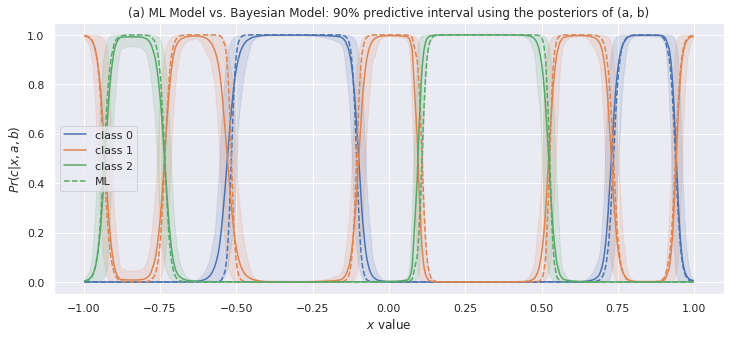

In [134]:
##### BAYESIAN MODEL

### Get classifier output for the whole dataset and for many samples of the last layer's weights
n_samples = 100       
with torch.no_grad():
    # Compute deterministic NN output
    h = features(x_test)
    cov_ab = flat_to_triangular(cov_ab_params)
    y_all = []
    for i in range(n_samples):
        # Sample last layer's weights from posterior q(a, b)
        ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        # Compute last layer output (the logits) with the weights just sampled
        y = h @ a + b    # shape: (N, n_classes)
        
        y_all.append(y.softmax(1).unsqueeze(0).cpu().numpy())

y_all = np.concatenate(y_all, axis=0)  # shape: (n_samples, N, n_classes)


### Get predictions (argmax) for all samples of weights (a,b)
pred_class = np.argmax(y_all, axis=-1)   # tensor of indices, shape (n_samples, N)
pred_class_onehot = onehot(pred_class)
pred_class_mean = pred_class_onehot.mean(0)   # shape (N, n_classes)
# pred_class_mean: for each input point a vector of size n_classes that sums to 1


### Get confusion matrix based on those samples
conf_matrix = np.zeros((n_classes, n_classes))
for i in range(N_test):
    conf_matrix[t_values_test[i]] += pred_class_mean[i]
conf_matrix /= conf_matrix.sum(1, keepdims=True)


##### ML MODEL

### Get classifier output for the whole dataset and for many samples of the last layer's weights
n_samples = 1       
with torch.no_grad():
    # Compute deterministic NN output
    h = ml_features(x_test.cpu())
    ml_y_all = []
    for i in range(n_samples):
        ab_sample = ml_mu_ab
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        # Compute last layer output (the logits) with the weights just sampled
        y = h @ a + b    # shape: (N, n_classes)
        
        ml_y_all.append(y.softmax(1).unsqueeze(0).cpu().numpy())

ml_y_all = np.concatenate(ml_y_all, axis=0)  # shape: (n_samples, N, n_classes)


### Get predictions (argmax) for all samples of weights (a,b)
ml_pred_class = np.argmax(ml_y_all, axis=-1)   # tensor of indices, shape (n_samples, N)
ml_pred_class_onehot = onehot(ml_pred_class)
ml_pred_class_mean = ml_pred_class_onehot.mean(0)   # shape (N, n_classes)
# pred_class_mean: for each input point a vector of size n_classes that sums to 1


### Get confusion matrix based on those samples
ml_conf_matrix = np.zeros((n_classes, n_classes))
for i in range(N_test):
    ml_conf_matrix[t_values_test[i]] += ml_pred_class_mean[i]
ml_conf_matrix /= ml_conf_matrix.sum(1, keepdims=True)


### Plot class probability outputs of the classifier (distribution over different samples of a,b)
y_lower = np.percentile(y_all, 5, axis=0)
y_upper = np.percentile(y_all, 95, axis=0)
y_mean = np.mean(y_all, axis=0)
ml_y_mean = np.mean(ml_y_all, axis=0)
x_numpy = x_test.detach().cpu().numpy().flatten()
plt.figure(figsize=(12, 5))
for c in range(n_classes):
    plot(x_numpy, y_mean[:, c], y_lower[:, c], y_upper[:, c], color=sns.color_palette()[c],
         alpha=0.15, title='90% interval of {} samples of (a, b)'.format(n_samples), xlabel='$x$', ylabel='$Pr(c | x, a, b)$', 
         label='class {}'.format(c))
    if c == n_classes-1:
        plot(x_numpy, ml_y_mean[:, c], color=sns.color_palette()[c], linestyle='--', label='ML')
    else:
        plot(x_numpy, ml_y_mean[:, c], color=sns.color_palette()[c], linestyle='--')

plt.title('(a) ML Model vs. Bayesian Model: 90% predictive interval using the posteriors of (a, b)')
plt.xlabel(r'$x$ value')
plt.ylabel(r'$Pr(c | x, a, b)$')
plt.show()

#### Analysis

The plot (a) shows the predictive densities of the different model. As the Maximum Likelihood model is deterministic, this results only in a serie of point estimates. The Maximum Likelihood model is overconfident while the Bayesian accounts for uncertainty.

### Predictive Likelihood: comparing the models

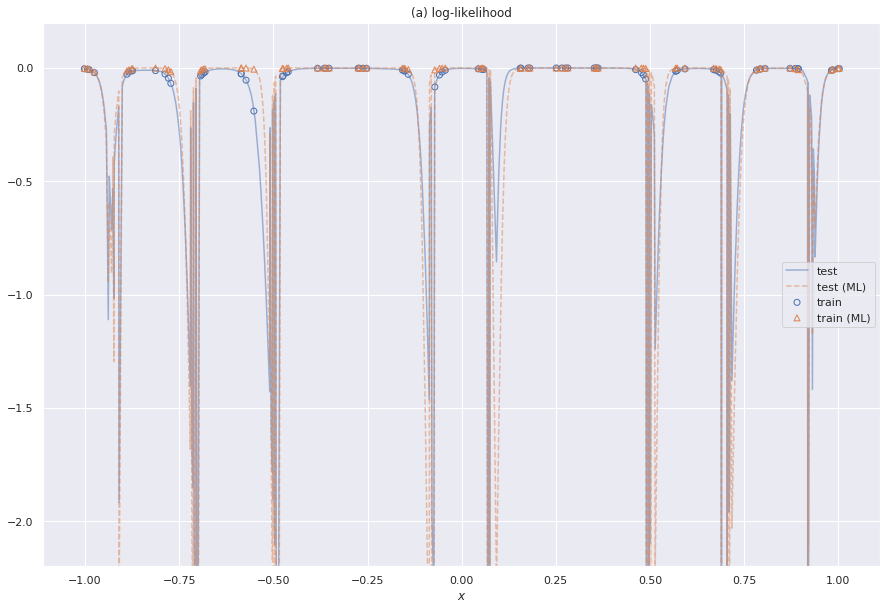

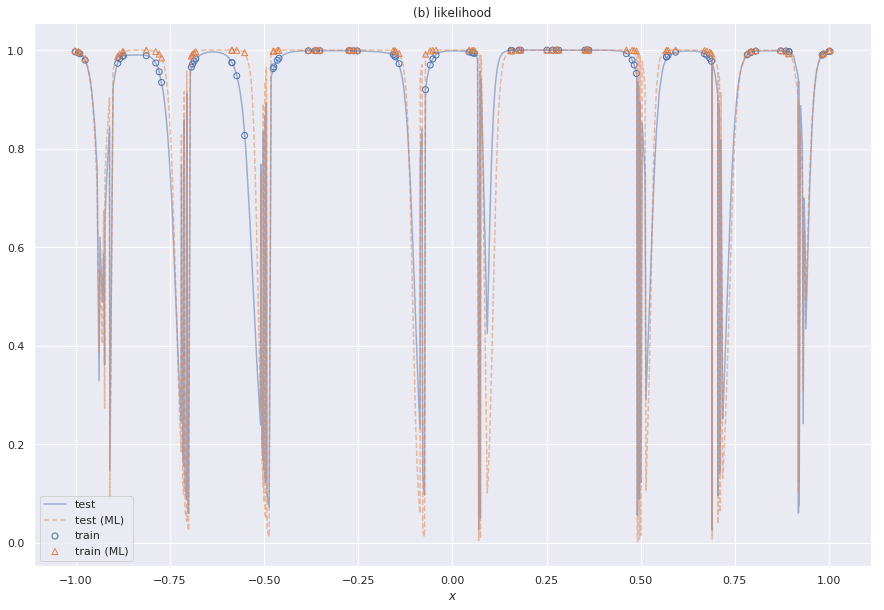

(b) Summary:
	LL training set: -1.27
	(ML) LL training set: -0.214
	LL test set (rescaled Ntr/Ntest): -12.8
	(ML) LL test set (rescaled Ntr/Ntest): -16.6


In [137]:
##### BAYESIAN MODEL

### Get classifier output for the whole dataset and for many samples of the last layer's weights
n_samples_test = 1000  # 100
recons_test = torch.zeros((n_samples_test, x_test.size(0)), device=x.device)
recons = torch.zeros((n_samples_test, x.size(0)), device=x.device)
recons_test_ml = torch.zeros((1, x_test.size(0)), device=x.device)
recons_ml = torch.zeros((1, x.size(0)), device=x.device)
with torch.no_grad():
    # Compute deterministic NN output
    h = features(x_test)
    cov_ab = flat_to_triangular(cov_ab_params)
    y_all = []   # test set
    for i in range(n_samples_test):
        # Sample last layer's weights from posterior q(a, b)
        ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        # Compute last layer output (the logits) with the weights just sampled
        y = h @ a + b    # shape: (N, n_classes)
        
        recons_test[i] = f.cross_entropy(y, t_values_test, reduction='none')
        y_all.append(y.softmax(1).unsqueeze(0).cpu().numpy())

    y_all = np.concatenate(y_all, axis=0)  # shape: (n_samples, N, n_classes)

    log_likelihood_test = (log_sum_exp(-recons_test, dim=0) - np.log(n_samples_test)).squeeze().detach().cpu().numpy()

    
    ## ML model
    h = ml_features(x_test)
    ab_sample = ml_mu_ab
    a, b = ab_sample[:-b_size], ab_sample[-b_size:]
    a = a.view(a_shape)
    b = b.unsqueeze(0)

    # Compute last layer output (the logits) with the weights just sampled
    y = h @ a + b    # shape: (N, n_classes)

    recons_test_ml[0] = f.cross_entropy(y, t_values_test, reduction='none')

    log_likelihood_test_ml = (log_sum_exp(-recons_test_ml, dim=0) - np.log(1)).squeeze().detach().cpu().numpy()

        
    # Compute deterministic NN output
    h = features(x)
    cov_ab = flat_to_triangular(cov_ab_params)
    for i in range(n_samples_test):
        # Sample last layer's weights from posterior q(a, b)
        ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        # Compute last layer output (the logits) with the weights just sampled
        y = h @ a + b    # shape: (N, n_classes)
        
        recons[i] = f.cross_entropy(y, t_values, reduction='none')

    log_likelihood = (log_sum_exp(-recons, dim=0) - np.log(n_samples_test)).squeeze().detach().cpu().numpy()

    
    ## ML model
    h = ml_features(x)
    cov_ab = flat_to_triangular(cov_ab_params)
    ab_sample = ml_mu_ab
    a, b = ab_sample[:-b_size], ab_sample[-b_size:]
    a = a.view(a_shape)
    b = b.unsqueeze(0)

    # Compute last layer output (the logits) with the weights just sampled
    y = h @ a + b    # shape: (N, n_classes)

    recons_ml[0] = f.cross_entropy(y, t_values, reduction='none')

    log_likelihood_ml = (log_sum_exp(-recons_ml, dim=0) - np.log(1)).squeeze().detach().cpu().numpy()


x_test_numpy = x_test.detach().cpu().numpy().flatten()
x_numpy = x.detach().cpu().numpy().flatten()
plt.figure(figsize=(15, 10))
plt.scatter(x_numpy, log_likelihood, label='train', color=sns.color_palette()[0], facecolors='none')
plt.scatter(x_numpy, log_likelihood_ml, label='train (ML)', color=sns.color_palette()[1], facecolors='none', marker='^')
plot(x_test_numpy, log_likelihood_test, title='(a) log-likelihood', label='test', line_alpha=0.5, xlabel='$x$')
plot(x_test_numpy, log_likelihood_test_ml, title='(a) log-likelihood', label='test (ML)', line_alpha=0.5, linestyle='--', xlabel='$x$')
plt.ylim([-2.2, .2])
plt.show()
plt.figure(figsize=(15, 10))
plt.scatter(x_numpy, np.exp(log_likelihood), label='train', color=sns.color_palette()[0], facecolors='none')
plt.scatter(x_numpy, np.exp(log_likelihood_ml), label='train (ML)', color=sns.color_palette()[1], facecolors='none', marker='^')
plot(x_test_numpy, np.exp(log_likelihood_test), title='(b) likelihood', label='test', line_alpha=0.5, xlabel='$x$')
plot(x_test_numpy, np.exp(log_likelihood_test_ml), title='(b) likelihood', label='test (ML)', line_alpha=0.5, linestyle='--', xlabel='$x$')
plt.show()

print("(b) Summary:")
print("\tLL training set: {:.3g}".format(log_likelihood.sum()))
print("\t(ML) LL training set: {:.3g}".format(log_likelihood_ml.sum()))
print("\tLL test set (rescaled Ntr/Ntest): {:.3g}".format(log_likelihood_test.mean()*N))
print("\t(ML) LL test set (rescaled Ntr/Ntest): {:.3g}".format(log_likelihood_test_ml.mean()*N))

#### Analysis

The Maximum Likelihood model tends to be overconfident, as showed by the visualization of the conficence interval in the previous plots. However, this simple visual assessement is not enough to judge that the Bayesian Model is a better model.

In the figure (a), we display the likelihood of the two models both for the training set and the test set (predictive performance). While the likelihoods are comparable in the intervals for which the class does not vary, in the uncertain intervals, the Maximum Likelihood model is penalized much more than the Bayesian Model. This is the direct consequence of the Maximum Likelihood model being overconfident and placing high probability mass everywhere whereas the Bayesian Model predicts more tempered probability distributions when uncertain.

The summary of the likelihoods (b) reinforces this picture further: the Maximum Likelihood model performs better than the Bayesian model on the training set (higher likelihood) but performs worse than the Bayesian model on the test set (predictive likelihood): the maximum likelihood model overfits. This measure allows to compare the two model and asses that the Bayesian model is a better model according to the predictive likelihood. 

### Posterior

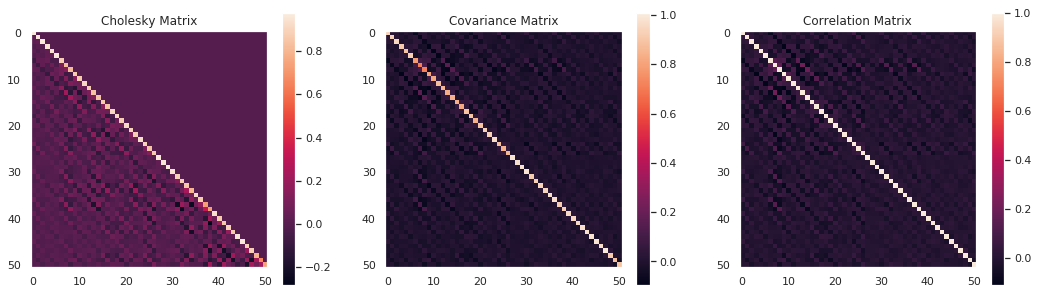

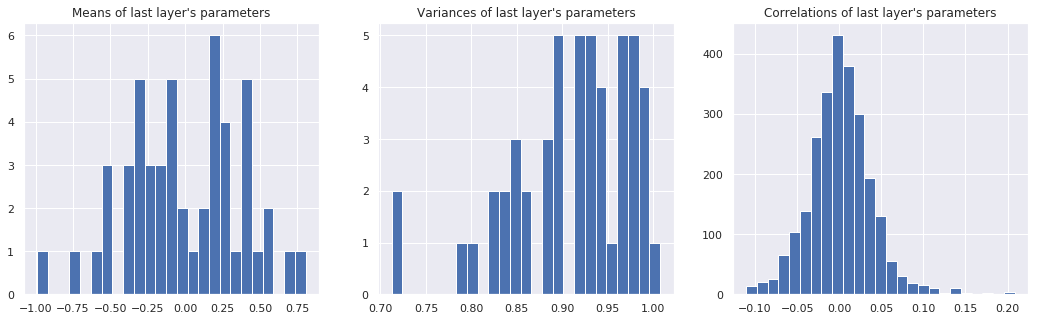

In [139]:
L = make_cholesky(logvar_ab, cov_ab).detach().cpu().numpy()
Cov = L @ L.T
inv_stds = np.diag(np.diag(Cov)**(-0.5))
Corr = inv_stds @ Cov @ inv_stds

plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
plt.title("Cholesky Matrix"), plt.grid(False)
plt.imshow(L)
plt.colorbar()

plt.subplot(1,3,2)
plt.title("Covariance Matrix"), plt.grid(False)
plt.imshow(Cov)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("Correlation Matrix"), plt.grid(False)
plt.imshow(Corr)
plt.colorbar()
plt.show()

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.title("Means of last layer's parameters")
plt.hist(mu_ab.detach(), bins=25)
plt.subplot(1, 3, 2)
plt.title("Variances of last layer's parameters")
plt.hist(np.diag(Cov), bins=25)
plt.subplot(1, 3, 3)
plt.title("Correlations of last layer's parameters")  # corr coefficients between pairs of DIFFERENT variables
correlations = Corr[~np.eye(Corr.shape[0], dtype=bool)]
plt.hist(correlations, bins=25)
plt.show()

#### Analysis

The above picture shows that our model is able to learn a posterior with non-trivial covariance.

## 6. Application to the classification of hand-written digits